# Association table stats

I have some questions about what "good" cross match routines will do, and I think they can be answered just using the association table we created for the Macauff incubator. This association table provides a pre-computed cross-match between GAIA DR? and catwise2020.

Questions:
- Considering the highest-likelihood counterpart pairing:
    - What does the distribution of counterpart distances look like?
    - What's a minimum / maximum counterpart distance?
    - Does the maximum counterpart distance fit with we would expect the margin distance to be?
    - What percent of counterparts are in the same/nested healpix pixel? vs how many are in neighboring pixels?

I'm going to start with just looking at a single pixel's worth of association data, just to poke.

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import astropy.units as u
import numpy as np
from hipscat.catalog.association_catalog import AssociationCatalog
from hipscat.io import paths
import os
import tqdm
import matplotlib.pyplot as plt

single_path = '/data3/epyc/data3/hipscat/test_catalogs/macauff_association/Norder=2/Dir=0/Npix=0.parquet'

pq.read_metadata(single_path).schema

required group field_id=-1 schema {
  optional int64 field_id=-1 gaia_source_id;
  optional double field_id=-1 gaia_ra;
  optional double field_id=-1 gaia_dec;
  optional double field_id=-1 BP;
  optional double field_id=-1 G;
  optional double field_id=-1 RP;
  optional binary field_id=-1 catwise_name (String);
  optional double field_id=-1 catwise_ra;
  optional double field_id=-1 catwise_dec;
  optional double field_id=-1 W1;
  optional double field_id=-1 W2;
  optional double field_id=-1 match_p;
  optional double field_id=-1 separation;
  optional double field_id=-1 eta;
  optional double field_id=-1 xi;
  optional double field_id=-1 gaia_avg_cont;
  optional double field_id=-1 catwise_avg_cont;
  optional double field_id=-1 gaia_cont_f1;
  optional double field_id=-1 gaia_cont_f10;
  optional double field_id=-1 catwise_cont_f1;
  optional double field_id=-1 catwise_cont_f10;
  optional double field_id=-1 catwise_fit_sig;
  optional int64 field_id=-1 Norder;
  optional int64 field

In [2]:
assoc_frame = pd.read_parquet(single_path)

In [3]:
assoc_frame.head(5)[["gaia_source_id", "catwise_name", "match_p", "separation"]]

,gaia_source_id,catwise_name,match_p,separation
0,1488120269370752,J025039.37+021935.2,0.999997,0.117720
1,1488227643566208,J025053.81+021930.4,1.000000,0.050823
2,1488257707996800,J025049.75+022003.7,0.999998,0.114491
3,1488296363118848,J025052.95+022039.5,0.999998,0.075686
4,1488330722779776,J025055.54+022034.8,0.999861,0.509319


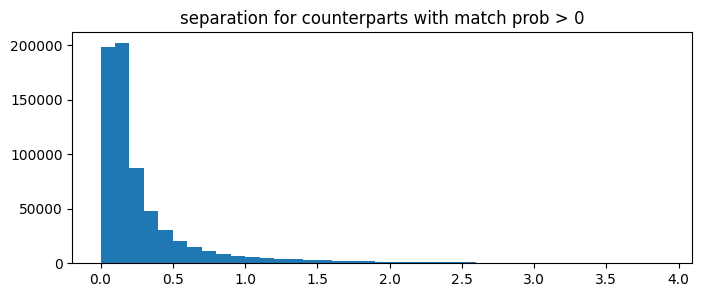

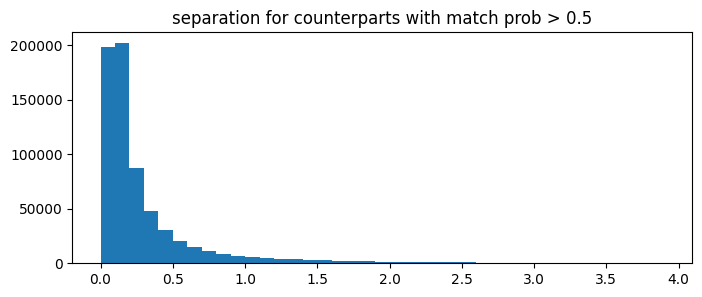

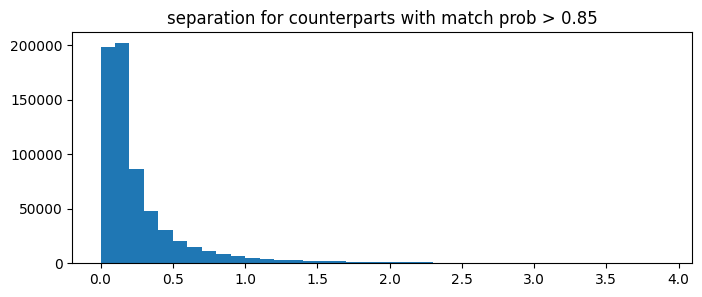

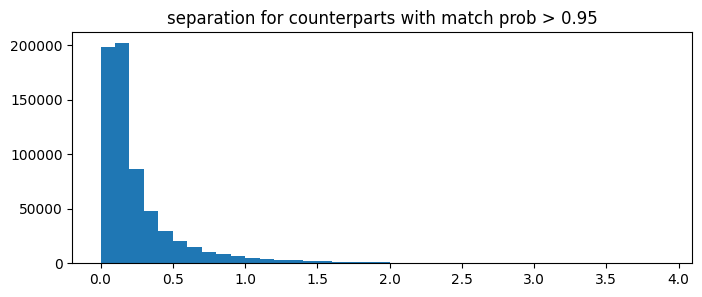

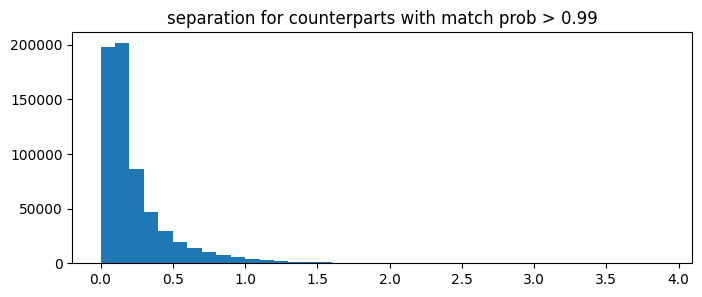

In [4]:
sep_bins = np.arange(0, 4, .1)

for threshold in [0, 0.5, 0.85, 0.95, 0.99]:
    hist, bins = np.histogram(assoc_frame["separation"][assoc_frame["match_p"] > threshold], bins=sep_bins)

    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    fig, ax = plt.subplots(figsize=(8,3))
    ax.bar(center, hist, align='center', width=width)
    plt.title(f"separation for counterparts with match prob > {threshold}")
    plt.show()

I think I've determined I like the look of the match_p > 0.95 plot, and I'd like to look at what that looks like for the FULL data set. 

Unfortunately, I don't think I can use LSDB to do this. The catalog isn't really a catalog - it's an association table, and I don't think we offer arbitrary dask pipelines over the data. But I think I'll be ok. How many partitions are there?

In [5]:
catalog_dir = '/data3/epyc/data3/hipscat/test_catalogs/macauff_association/'
catalog = AssociationCatalog.read_from_hipscat(catalog_dir)
len(catalog.get_healpix_pixels())

3933

In [6]:
full_histo = np.zeros(39, dtype=np.int64)
sep_bins = np.arange(0, 4, .1)

for pixel in tqdm.tqdm(catalog.get_healpix_pixels()):
    file_path = paths.pixel_catalog_file(catalog_dir, pixel.order, pixel.pixel)
    assoc_frame = pd.read_parquet(single_path, columns=["separation", "match_p"])
    hist, bins = np.histogram(assoc_frame["separation"][assoc_frame["match_p"] > .95], bins=sep_bins)
    full_histo += hist

100%|██████████| 3933/3933 [07:01<00:00,  9.34it/s]


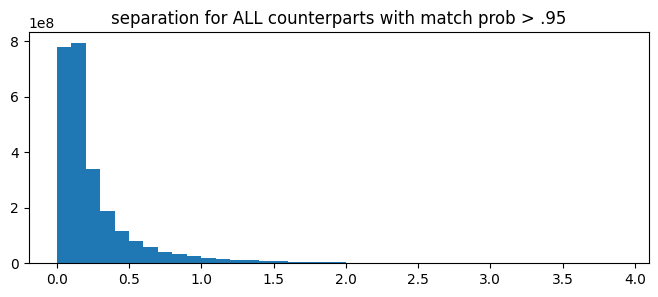

In [7]:
width = np.diff(sep_bins)
center = (sep_bins[:-1] + sep_bins[1:]) / 2

fig, ax = plt.subplots(figsize=(8,3))
ax.bar(center, full_histo, align='center', width=width)
plt.title("separation for ALL counterparts with match prob > .95")
plt.show()

Well, that only took 7 minutes to run through the data. Not so bad. And after talking to Alex, a real astrostatistician, there was lots of talk of priors and probabilities and likelihoods. But the next easy step that I could actually achieve today is a 2d histogram plot of match_p vs separation. 

So I'm going to try that.

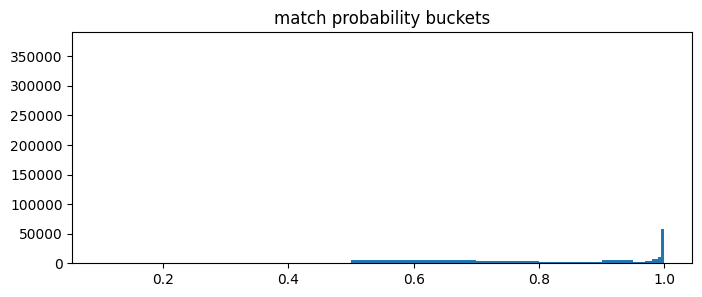

In [8]:
match_bins = np.array([.1, .2, .3, .4, .5, .7, .8, 
                       .85, .9, .95, .96, .97, .98, .99, .995,.9995,.99995, .99999, 1])
sep_bins = np.arange(0, 4, .1)
hist, bins = np.histogram(assoc_frame["match_p"], bins=match_bins)
width = np.diff(bins)
center = (bins[:-1] + bins[1:]) / 2

fig, ax = plt.subplots(figsize=(8,3))
ax.bar(center, hist, align='center', width=width)
plt.title("match probability buckets")
plt.show()

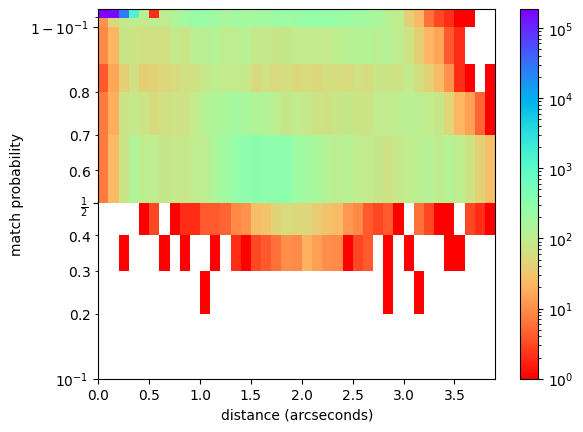

In [9]:
H, xedges, yedges = np.histogram2d(assoc_frame["separation"], 
                                   assoc_frame["match_p"], 
                                   bins=(sep_bins, match_bins))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig, ax = plt.subplots()
X, Y = np.meshgrid(xedges, yedges)
pc = ax.pcolormesh(X, Y, H, shading='flat', cmap="rainbow_r", norm="log")
ax.set_title("")
ax.set_xlabel('distance (arcseconds)')
ax.set_ylabel('match probability')
ax.set_yscale('logit')
fig.colorbar(pc)
plt.show()

In [15]:
full_2d = np.zeros((39,18))

for pixel in tqdm.tqdm(catalog.get_healpix_pixels()):
    file_path = paths.pixel_catalog_file(catalog_dir, pixel.order, pixel.pixel)
    assoc_frame = pd.read_parquet(single_path, columns=["separation", "match_p"])
    partial_histogram, _, _ = np.histogram2d(assoc_frame["separation"], 
                                   assoc_frame["match_p"], 
                                   bins=(sep_bins, match_bins))
    full_2d += partial_histogram

100%|██████████| 3933/3933 [05:03<00:00, 12.94it/s]


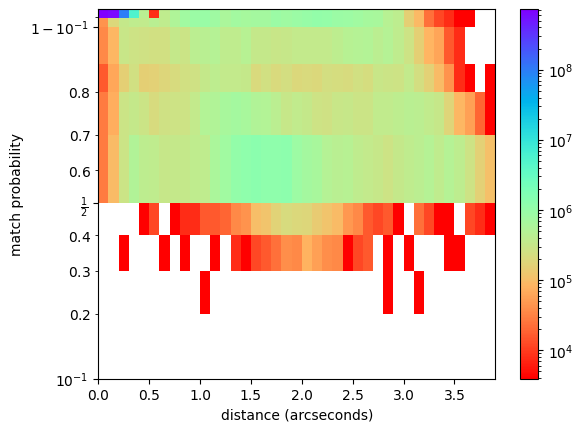

In [16]:
full_2d = full_2d.T

fig, ax = plt.subplots()
X, Y = np.meshgrid(xedges, yedges)
pc = ax.pcolormesh(X, Y, full_2d, shading='flat', cmap="rainbow_r", norm="log")
ax.set_title("")
ax.set_xlabel('distance (arcseconds)')
ax.set_ylabel('match probability')
ax.set_yscale('logit')
fig.colorbar(pc)
plt.show()